In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%%time 
df_train = pd.read_pickle('../input/feats/df_trn_feat0.pkl')

CPU times: user 44 ms, sys: 52 ms, total: 96 ms
Wall time: 94.3 ms


In [3]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability'],
      dtype='object')

interaction 

- uidx x param_1
- ~~uidx x image_top_1~~
- uidx x iidx
- ...

In [4]:
df_train['image_top_1'] = df_train.image_top_1.fillna(-999).astype('uint16')


In [5]:
df_cnt_by_uidx_image = \
    df_train.groupby(['uidx','image_top_1']).size().reset_index().rename(columns={0:'cnt_by_uidx_image'})

In [6]:
df_param1_cnts = df_train.groupby(['uidx','param_1']).size().astype('int32').\
                    reset_index().rename(columns={0:'cnt_by_uidx_param1'})

In [7]:
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import TruncatedSVD

In [8]:
df_train.uidx.dtypes

dtype('uint32')

In [9]:
df_train.param_1.dtype

category

In [10]:
df_train['param1_hash'] = df_train.param_1.apply(hash)

df_train['param_1_label'] = LabelEncoder().fit_transform(df_train.param1_hash).astype('uint16')

In [11]:
df_train = df_train.merge(df_param1_cnts,how='left',on=['uidx','param_1'])

In [12]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability', 'param1_hash', 'param_1_label',
       'cnt_by_uidx_param1'],
      dtype='object')

In [13]:
import scipy.sparse as sp

In [54]:
# inter = df_train[['uidx','param_1_label']]

# I = df_train.uidx.as_matrix()
# J = df_train.param_1_label.as_matrix()
# V = df_train.cnt_by_uidx_param1.as_matrix()

# inter_sp = sp.coo_matrix((V,(I,J)),dtype='uint16')

# svd = TruncatedSVD(n_components=5, random_state=0)
# uidx_param1_svd = svd.fit_transform(inter_sp)


# df_train.cnt_by_uidx_param1.median() ## 右偏嚴重

In [14]:
inter = df_train[['uidx','param_1_label']]

I = df_train.uidx.as_matrix()
J = df_train.param_1_label.as_matrix()
V = df_train.cnt_by_uidx_param1.apply(np.log1p).as_matrix()

inter_sp = sp.coo_matrix((V,(I,J)),dtype='uint16')

svd = TruncatedSVD(n_components=5, random_state=0)
uidx_param1_svd = svd.fit_transform(inter_sp)


In [18]:
inter_sp

<771769x61947 sparse matrix of type '<class 'numpy.uint16'>'
	with 1030530 stored elements in COOrdinate format>

In [19]:
uidx_param1_svd.shape

(771769, 5)

In [20]:
df_uidx_param1_svd = pd.DataFrame(uidx_param1_svd)
df_uidx_param1_svd['uidx'] = df_train.uidx.unique()

In [24]:
df_train = df_train.merge(df_uidx_param1_svd,how='left',on='uidx')
df_train.columns

Index([                'uidx',                 'iidx',                  'iid',
          'region_city_label',              'tit_len',             'desc_len',
            'activation_date',                'month',                  'day',
                    'weekday',              'param_1',              'param_2',
                    'param_3',            'user_type', 'parent_category_name',
                      'price',        'category_name',          'image_top_1',
             'ads_cnt_by_uid',       'ads_cnt_by_iid',     'deal_probability',
                'param1_hash',        'param_1_label',   'cnt_by_uidx_param1',
                            0,                      1,                      2,
                            3,                      4],
      dtype='object')

In [25]:
df_train[[0,1,2,3,4,'deal_probability']].corr()

,0,1,2,3,4,deal_probability
0,1.000000,-0.002323,-0.004184,-0.003261,-0.002489,-0.027276
1,-0.002323,1.000000,-0.001424,-0.001651,-0.000803,-0.014048
2,-0.004184,-0.001424,1.000000,-0.028751,-0.001462,-0.021036
3,-0.003261,-0.001651,-0.028751,1.000000,-0.001075,-0.018619
4,-0.002489,-0.000803,-0.001462,-0.001075,1.000000,-0.015087
deal_probability,-0.027276,-0.014048,-0.021036,-0.018619,-0.015087,1.000000


In [30]:
df_train[['image_top_1','deal_probability']].corr() # ????

,image_top_1,deal_probability
image_top_1,1.000000,0.066873
deal_probability,0.066873,1.000000


In [27]:
df_train.corr().deal_probability

uidx                  0.138035
iidx                 -0.060865
iid                  -0.000062
region_city_label    -0.007091
tit_len               0.016143
desc_len             -0.000968
month                 0.003555
day                  -0.002379
weekday               0.002096
price                -0.001097
image_top_1           0.066873
ads_cnt_by_uid       -0.062903
ads_cnt_by_iid        0.121960
deal_probability      1.000000
param_1_label         0.012996
cnt_by_uidx_param1   -0.067902
0                    -0.027276
1                    -0.014048
2                    -0.021036
3                    -0.018619
4                    -0.015087
Name: deal_probability, dtype: float64

In [15]:
tmp = df_train.groupby(['uidx','param_1']).size().value_counts()
y = np.log1p(tmp)

In [41]:
y_df.head()

,index,0
0,1,13.585700
1,2,11.452793
2,3,10.429221
3,4,9.705037
4,5,9.145162


In [44]:
y_df = y.to_frame()
y_df.reset_index(inplace=True)
y_df.columns = ['no','cnt_log1p']

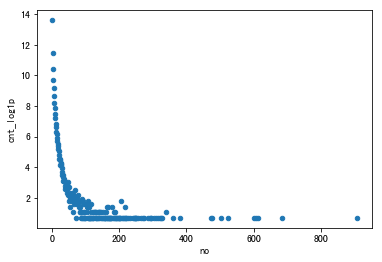

In [46]:
y_df.plot(kind='scatter',x='no',y='cnt_log1p')

In [54]:
tmp = df_train.groupby(['uidx','param_1']).size().reset_index().rename(columns={0:'cnt'})

In [5]:
df_train['params'] = df_train['param_1'].astype(str) + ' ' + df_train['param_2'].astype(str) + ' '+df_train['param_3'].astype(str)
df_train['params'] = df_train['params'].astype('category')

In [6]:
df_train.groupby('params').size().sort_values(ascending=False)

params
nan nan nan                                61576
Другое nan nan                             27874
Игрушки nan nan                            26442
Детские коляски nan nan                    26248
Аксессуары nan nan                         23839
Стройматериалы nan nan                     20197
Продам 2 Вторичка                          18617
iPhone nan nan                             18381
Продам 1 Вторичка                          17500
Кровати, диваны и кресла nan nan           17419
Продам Дом nan                             17175
Женская одежда Платья и юбки 42–44 (S)     16550
Женская одежда Верхняя одежда 42–44 (S)    16058
Инструменты nan nan                        15904
Женская одежда Обувь 38                    14823
Женская одежда Обувь 37                    14367
Детская мебель nan nan                     14251
Женская одежда Верхняя одежда 44–46 (M)    13952
Шкафы и комоды nan nan                     11417
Женская одежда Другое nan                  11403
Приборы и акс

In [10]:
hash('Для мальчиков Обувь 36')

-2161061452945458590

In [12]:
import scipy.sparse as sp 

In [11]:
df_cnt_by_uidx_params = df_train.groupby(['uidx','params']).size().reset_index().rename(columns={0:'cnt_by_uidx_para'})

,uidx,params,cnt_by_uidx_para
0,0,Постельные принадлежности nan nan,1
1,1,Другое nan nan,1
2,2,"Видео, DVD и Blu-ray плееры nan nan",1
3,2,"Комплектующие CD, DVD и Blu-ray приводы nan",1
4,3,Автомобильные кресла nan nan,1
5,4,С пробегом ВАЗ (LADA) 2110,1
6,5,Автомобильные кресла nan nan,1
7,6,Сантехника и сауна nan nan,1
8,7,Для девочек Верхняя одежда 74-80 см (7-12 мес),1
9,7,Для мальчиков Верхняя одежда 86-92 см (1-2 года),2


In [9]:
df_train.groupby(['uidx','iidx']).size()

1    1503424
dtype: int64

In [11]:
from libfm import *

Using TensorFlow backend.


In [35]:
def create_label_encoding_with_min_count(df, column, min_count=50):
    column_counts = df.groupby([column])[column].transform("count").astype(int)
    column_values = np.where(column_counts >= min_count, df[column], "")
    df[column+"_label"] = LabelEncoder().fit_transform(column_values)
    
    return df[column+"_label"]

In [45]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability'],
      dtype='object')

In [13]:
import scipy.sparse as sp

In [14]:
from sklearn.decomposition import TruncatedSVD

In [33]:
from sklearn.preprocessing import LabelEncoder

In [46]:
df_train.groupby(['param_1']).size()

param_1
ASUS                           720
Acer                            58
Alcatel                       1225
BQ                             288
BlackBerry                     105
DEXP                           369
Explay                         345
Fly                           1289
HTC                           1110
Highscreen                     324
Huawei                         674
IT, интернет, телеком         1643
LG                            1378
Lenovo                        1935
MP3-плееры                     893
MTS                            195
Meizu                          762
Micromax                       540
Microsoft                      502
Motorola                       193
Nokia                         3071
Panasonic                        7
Philips                        374
Prestigio                      302
Samsung                       8330
Siemens                         62
SkyLink                          1
Sony                          2552
Vertu       

In [45]:
col_cnts = df_train.groupby(['param_1'])['param_1'].transform('count').astype(int)
df_train['param_1_label']=LabelEncoder().fit_transform(col_cnts)
# col_cnts = np.where(col_cnts>=10,df_train['param_1'],"")

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# def inter_2_feat(df,inter_feats):
#     assert len(inter_feats)==2
#     inter_2 = df[inter_feats]
#     col1,col2 = inter_feats[0], inter_feats[1]
    
#     df.groupby(inter_feats).size()
# #     I = df[col1].as_matrix()
# #     J = df[col2].as_matrix()
# #     V = 

In [32]:
df_train.groupby(['uidx','param_1']).size().reset_index()

,uidx,param_1,0
0,0,Постельные принадлежности,1
1,1,Другое,1
2,2,"Видео, DVD и Blu-ray плееры",1
3,2,Комплектующие,1
4,3,Автомобильные кресла,1
5,4,С пробегом,1
6,5,Автомобильные кресла,1
7,6,Сантехника и сауна,1
8,7,Для девочек,1
9,7,Для мальчиков,3


In [45]:
uidx_sp = df_train[['uidx','iidx']]

I = df_train.uidx.as_matrix()
J = df_train.iidx.as_matrix()
V = np.ones(df_train.shape[0])

ui_trn_sp = sp.coo_matrix((V,(I,J)),dtype='uint8')

svd = TruncatedSVD(n_components=5, random_state=0)
uidx_svd = svd.fit_transform(ui_trn_sp)


In [47]:
df_uidx_svd = pd.DataFrame(uidx_svd)
df_uidx_svd['uidx'] = df_train.uidx.unique()

In [48]:
df_train = df_train.merge(df_uidx_svd,how='left',on='uidx')

In [49]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability', 'param1_hash', 'param_1_label',
       'cnt_by_uidx_param1', '0_x', '1_x', '2_x', '3_x', '4_x', '0_y', '1_y',
       '2_y', '3_y', '4_y'],
      dtype='object')

In [ ]:
%%time 


In [51]:
df_train[['0_x','1_x','2_x','3_x','4_x','0_y','1_y','2_y','3_y','4_y','deal_probability']].corr()

,0_x,1_x,2_x,3_x,4_x,0_y,1_y,2_y,3_y,4_y,deal_probability
0_x,1.000000,-0.005622,-0.002918,-0.004210,-0.002442,-0.048742,-0.032014,-0.022795,-0.017335,-0.015582,-0.030598
1_x,-0.005622,1.000000,-0.002264,-0.002959,-0.005435,-0.028143,-0.019244,-0.013578,-0.010939,-0.009373,-0.015778
2_x,-0.002918,-0.002264,1.000000,-0.001231,-0.000717,-0.014423,-0.008972,-0.005705,-0.004137,-0.002681,-0.015322
3_x,-0.004210,-0.002959,-0.001231,1.000000,-0.000434,-0.018008,-0.010165,-0.005990,-0.004719,-0.004070,-0.018780
4_x,-0.002442,-0.005435,-0.000717,-0.000434,1.000000,-0.010659,-0.006851,-0.004183,-0.002929,-0.002131,-0.012133
0_y,-0.048742,-0.028143,-0.014423,-0.018008,-0.010659,1.000000,0.508835,0.090404,0.014104,-0.009167,-0.008687
1_y,-0.032014,-0.019244,-0.008972,-0.010165,-0.006851,0.508835,1.000000,0.479784,0.138502,0.069193,-0.081228
2_y,-0.022795,-0.013578,-0.005705,-0.005990,-0.004183,0.090404,0.479784,1.000000,0.499284,0.176348,-0.059109
3_y,-0.017335,-0.010939,-0.004137,-0.004719,-0.002929,0.014104,0.138502,0.499284,1.000000,0.495880,-0.050277
4_y,-0.015582,-0.009373,-0.002681,-0.004070,-0.002131,-0.009167,0.069193,0.176348,0.495880,1.000000,-0.047595


In [ ]:
# feats = ['uidx','region_city2_label']
# fm_data = df_train.groupby(feats).size().reset_index().rename(columns={0:'cnt'})

In [40]:
# tmp = df_train.groupby(['uidx','param_1','param_2','param_3'])['uidx'].transform(lambda x:np.random.random()) ## faster and encode it correctly!!
# df_train['region_city_label'] = create_label_encoding_with_min_count(df_train, 'region_city', min_count=1).astype('uint16')

ValueError: Length mismatch: Expected axis has 640859 elements, new values have 1503424 elements

In [12]:
feats = ['uidx','param_1','param_2','param_3']
fm_data = df_train.groupby(feats).size().reset_index().rename(columns={0:'cnt'})

In [23]:
fm_data.cnt.value_counts()

1      458205
2       46158
3       11322
4        3744
5        1591
6         794
7         416
8         273
9         192
10        123
11         83
12         69
14         59
13         56
15         45
16         35
19         29
18         28
17         27
21         20
20         18
26         15
30         15
23         14
24         14
22         13
29         11
27         10
34         10
38         10
        ...  
42          2
46          2
85          2
121         1
107         1
112         1
101         1
139         1
125         1
189         1
156         1
131         1
98          1
150         1
64          1
73          1
92          1
91          1
90          1
87          1
86          1
84          1
82          1
75          1
72          1
48          1
231         1
60          1
61          1
253         1
Name: cnt, Length: 101, dtype: int64

In [34]:
fm_data['param_1']

0             С пробегом
1            Для девочек
2          Для мальчиков
3          Для мальчиков
4         Женская одежда
5         Женская одежда
6          Для мальчиков
7          Для мальчиков
8         Женская одежда
9         Женская одежда
10        Женская одежда
11        Женская одежда
12        Женская одежда
13           Для девочек
14           Для девочек
15                  Сдам
16         Для мальчиков
17        Женская одежда
18        Женская одежда
19        Мужская одежда
20        Женская одежда
21         Для мальчиков
22        Женская одежда
23            С пробегом
24         Для мальчиков
25        Женская одежда
26                Продам
27                 Сниму
28                 Сниму
29                Продам
               ...      
523548       Для девочек
523549    Женская одежда
523550     Для мальчиков
523551    Женская одежда
523552            Продам
523553        С пробегом
523554     Для мальчиков
523555       Для девочек
523556    Женская одежда
